In [1]:
%store -r sheyenne_grasslands_gdf caddo_grasslands_gdf data_dir

In [2]:
# Import necessary packages
import os
from math import floor, ceil

import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters

## Load in soil data

For each grassland, download at least one soil variable from the [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/) as raster data. 
    
* [Further POLARIS info](https://pubs.usgs.gov/publication/70170912)

* I'll look at soil pH, specifically the mean soil pH of 30x30 meter pieces of land for the 60-100 cm depth. *S. nutans* prefers a soil pH of [4.8 to 8.0](https://www.nrcs.usda.gov/plantmaterials/etpmcpg13196.pdf) and has a minimum [root depth of 24 inches, or about 61 cm](https://plants.sc.egov.usda.gov/plant-profile/SONU2/characteristics).

* Depths of the POLARIS data set is in cm.

* Need to use rioxarray to import

### Define functions for soil data download

In [3]:
#  Define the URL template to download soil data from POLARIS
def soil_url_temp(variable='variable',
                  statistic='statistic',
                  depth='depth'):
    """
    Create a URL template for downloading soil data from POLARIS.

    Parameters
    ----------
    variable : str
        The soil `variable` of interest.
    statistic : {'mean', 'mode', 'p5', 'p50', 'p95'}
        The `statistic` type of interest.
    depth : {'0_5', '5_15', '15_30', '30_60', '60_100', or '100_200'}
        The `depth` of interest in cm.

    Returns
    -------
    soil_url_template : str
        Template of the URL to download the soil data.
    """
    soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
                    "v1.0"
                    f"/{variable}"
                    f"/{statistic}"
                    f"/{depth}"
                    "/lat{min_lat}{max_lat}"
                    "_lon{min_lon}{max_lon}.tif")
    return soil_url_template

In [4]:
# Define site bounds
def define_site_bounds(site_gdf):
    """
    Identify the bounds of a geographic site.
     
    Specifically, this function creates a tuple with
    a DataArray of the site bounds and the minimum longitude,
    minimum latitude, maximum longitude, and maximum latitude of a site.

    Parameters
    ----------
    site_gdf : GeoDataFrame
        The GeoDataFrame of the site of interest.

    Returns
    -------
    site_bounds : DataArray
        A DataArray with the minimum and maximum longitude and
        minimum and maximum latitude of the site.
    site_bounds_min_lon : float
        The minimum longitude of the site.
    site_bounds_min_lat : float
        The minimum latitude of the site.
    site_bounds_max_lon : float
        The maximum longitude of the site.
    site_bounds_max_lat : float
        The maximum latitude of the site.
    """
    site_bounds = (site_bounds_min_lon,
                   site_bounds_min_lat,
                   site_bounds_max_lon,
                   site_bounds_max_lat) = (
                       site_gdf
                       .total_bounds)
    return (site_bounds, site_bounds_min_lon, site_bounds_min_lat,
    site_bounds_max_lon, site_bounds_max_lat)

In [5]:
# Process soil DataArrays
def process_soil_da(site_soil_dir,
                    soil_url_template,
                    site_bounds,
                    site_bounds_min_lon,
                    site_bounds_min_lat,
                    site_bounds_max_lon,
                    site_bounds_max_lat,
                    variable='variable',
                    statistic='statistic',
                    depth='depth'):
    """
    Save, open, scale, and crop raster soil data.

    Parameters
    ----------
    site_soil_dir : str
        The directory where the soil data will be saved.
    soil_url_template : str
        Template of the URL to download the soil data.
    site_bounds : DataArray
        A DataArray with the minimum and maximum longitude and
        minimum and maximum latitude of the site.
    site_bounds_min_lon : float
        The minimum longitude of the site.
    site_bounds_min_lat : float
        The minimum latitude of the site.
    site_bounds_max_lon : float
        The maximum longitude of the site.
    site_bounds_max_lat : float
        The maximum latitude of the site.
    variable : str
        The soil `variable` of interest.
    statistic : {'mean', 'mode', 'p5', 'p50', 'p95'}
        The `statistic` type of interest.
    depth : {'0_5', '5_15', '15_30', '30_60', '60_100', or '100_200'}
        The `depth` of interest in cm.

    Returns
    -------
    site_soil_das : list
        A list of DataArrays of soil data for the
        different rasters covering the site of interest.
    """
    site_soil_das = []
    # List out the soil files for download
    for min_lon in range(floor(site_bounds_min_lon),
                         ceil(site_bounds_max_lon)):
        for min_lat in range(floor(site_bounds_min_lat),
                             ceil(site_bounds_max_lat)):
            max_lon = min_lon + 1
            max_lat = min_lat + 1
            soil_url = soil_url_template.format(
                min_lat=min_lat,
                max_lat=max_lat,
                min_lon=min_lon,
                max_lon=max_lon)
            
            # Define file path for saving downloaded raster data
            soil_path = os.path.join(site_soil_dir,
                                     f"soil_{variable}_{statistic}_{depth}"
                                     f"_lat{min_lat}{max_lat}"
                                     f"_lon{min_lon}{max_lon}.tif")

            if not os.path.exists(soil_path):
                # Save raster data to soil path, mask and scale, squeeze
                soil_da = rxr.open_rasterio(
                    soil_url,
                    mask_and_scale=True
                    ).squeeze()
                soil_da.to_netcdf(soil_path)
                print(f'soil_da saved: {soil_path}')
            else:
                print(f'file already exists: {soil_path}')

            # Open and squeeze raster soil data
            soil_da = rxr.open_rasterio(
                soil_url,
                mask_and_scale=True
            ).squeeze()

            # Crop the raster soil data
            cropped_da = soil_da.rio.clip_box(*site_bounds)
            site_soil_das.append(cropped_da)
            print('Cropped')

    return site_soil_das

In [6]:
# Define data directory for the soil data
soil_ph_dir = os.path.join(data_dir, 'soil-ph')

os.makedirs(soil_ph_dir, exist_ok=True)

soil_ph_pattern = os.path.join (soil_ph_dir, '*.tif')
soil_ph_pattern

'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\soil-ph\\*.tif'

### Load in Sheyenne soil pH data

In [7]:
# Define Sheyenne Grassland bounds
sheyenne_bounds = define_site_bounds(sheyenne_grasslands_gdf)
sheyenne_bounds

(array([-97.46881033,  46.09534316, -96.93854828,  46.57204154]),
 np.float64(-97.46881033436894),
 np.float64(46.0953431579286),
 np.float64(-96.93854828332353),
 np.float64(46.57204154162918))

In [8]:
# Create Sheyenne soil pH url template
sheyenne_soil_url_template = soil_url_temp(variable='ph', statistic='mean', depth='60_100')
sheyenne_soil_url_template

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif'

In [9]:
# Process Sheyenne soil pH DataArrays
sheyenne_soil_ph_indiv_das = process_soil_da(soil_ph_dir,
                                             sheyenne_soil_url_template,
                                             sheyenne_bounds[0],
                                             sheyenne_bounds[1],
                                             sheyenne_bounds[2],
                                             sheyenne_bounds[3],
                                             sheyenne_bounds[4],
                                             variable='ph',
                                             statistic='mean',
                                             depth='60_100')

soil_da saved: C:\Users\riede\earth-analytics\data\habitat-suitability\soil-ph\soil_ph_mean_60_100_lat4647_lon-98-97.tif
Cropped
soil_da saved: C:\Users\riede\earth-analytics\data\habitat-suitability\soil-ph\soil_ph_mean_60_100_lat4647_lon-97-96.tif
Cropped


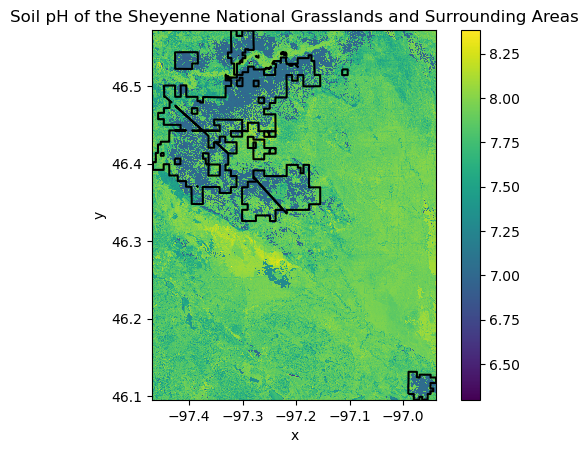

In [10]:
# Merge Sheyenne soil ph data tiles
sheyenne_soil_ph_da = merge_arrays(sheyenne_soil_ph_indiv_das)
sheyenne_soil_ph_da.plot()

# Plot Sheyenne National Grasslands on sheyenne_soil_ph_da
sheyenne_grasslands_gdf.to_crs(sheyenne_soil_ph_da.rio.crs).boundary.plot(ax = plt.gca(), color='black')

# Add titles and axes to plot
plt.title('Soil pH of the Sheyenne National Grasslands and Surrounding Areas')
plt.show()

### Load Caddo soil pH data

In [11]:
# Define Caddo Grassland bounds
caddo_bounds = define_site_bounds(caddo_grasslands_gdf)
caddo_bounds

(array([-96.16923458,  33.38543577, -95.85492674,  33.80186199]),
 np.float64(-96.1692345765796),
 np.float64(33.38543577462093),
 np.float64(-95.85492673757102),
 np.float64(33.80186198772292))

In [12]:
# Create Caddo soil pH url template
caddo_soil_url_template = soil_url_temp(variable='ph', statistic='mean', depth='60_100')
caddo_soil_url_template

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif'

In [13]:
# Process Caddo soil pH DataArrays
caddo_soil_ph_indiv_das = process_soil_da(soil_ph_dir,
                                          caddo_soil_url_template,
                                          caddo_bounds[0],
                                          caddo_bounds[1],
                                          caddo_bounds[2],
                                          caddo_bounds[3],
                                          caddo_bounds[4],
                                          variable='ph',
                                          statistic='mean',
                                          depth='60_100')

soil_da saved: C:\Users\riede\earth-analytics\data\habitat-suitability\soil-ph\soil_ph_mean_60_100_lat3334_lon-97-96.tif
Cropped
soil_da saved: C:\Users\riede\earth-analytics\data\habitat-suitability\soil-ph\soil_ph_mean_60_100_lat3334_lon-96-95.tif
Cropped


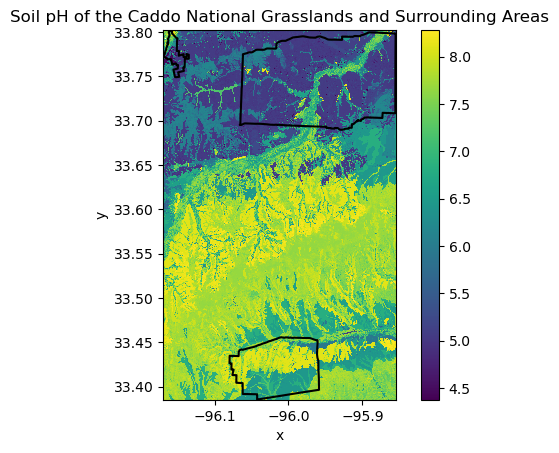

In [14]:
# Merge Caddo soil ph data tiles
caddo_soil_ph_da = merge_arrays(caddo_soil_ph_indiv_das)
caddo_soil_ph_da.plot()

# Plot Caddo National Grasslands on caddo_soil_ph_da plot
caddo_grasslands_gdf.to_crs(caddo_soil_ph_da.rio.crs).boundary.plot(ax = plt.gca(), color='black')
plt.title('Soil pH of the Caddo National Grasslands and Surrounding Areas')
plt.show()

In [15]:
%store sheyenne_soil_ph_da caddo_soil_ph_da

Stored 'sheyenne_soil_ph_da' (DataArray)
Stored 'caddo_soil_ph_da' (DataArray)


### *The code below is pseudocode for my attempt to download and process the soil data for both grassland sites at once. The first code cell below worked, I was unable to get the second code cell to loop through the bounds properly to crop the rasters.*

In [16]:
# # Loop through bounds of Caddo and Sheyenne

# # c_s_grasslands_gdf = grasslands_gdf[grasslands_gdf['GRASSLANDN'].isin(['Sheyenne National Grassland', 'Caddo National Grassland'])]
# c_s_grasslands_gdf = [caddo_grasslands_gdf, sheyenne_grasslands_gdf]
# c_s_grasslands_gdf

# bounds = []
# soil_urls = []
# for gdf in c_s_grasslands_gdf:
#     bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
#     gdf
#     #.to_crs(ccrs.UTM(zone=14))
#     .total_bounds)
#     bounds.append((bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat))
    
# bounds_df = pd.DataFrame(bounds).rename(
#     index={0: 'Caddo Bounds', 1: 'Sheyenne Bounds'},
#     columns={0: 'min_lon', 1: 'min_lat', 2: 'max_lon', 3: 'max_lat'})
# display(bounds_df)

# #  Define the Caddo download URL template for the soil data
# soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
#             "v1.0"
#             "/ph"
#             "/mean"
#             "/60_100"
#             "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")
# display(soil_url_template)

# # Maybe turn soil_urls into a dictionary and instead of appending in line 40 add results to dictionary
# # Check notebook 92 from redlining code
# soil_urls = []
# for site_name, site_bounds_df in bounds_df.groupby(level=0):
#     print(site_name)
#     for min_lon in range(floor(site_bounds_df.min_lon), ceil(site_bounds_df.max_lon)):
#         for min_lat in range(floor(site_bounds_df.min_lat), ceil(site_bounds_df.max_lat)):
#             print(min_lon, min_lat)
#             soil_url = soil_url_template.format(
#                 min_lat=min_lat, max_lat=min_lat+1,
#                 min_lon=min_lon, max_lon=min_lon+1)
#             soil_urls.append(soil_url)
# display(soil_urls)

In [17]:
# all_soil_das = []
# # Loop through each of the soil files
# for url in soil_urls:
#     print(url)
#     # Download raster data

#     # Unzip the raster data

#     # Extract metadata from the file name

#     # Only download once -- Save raster data to the disk

#     # Load the raster data into Python, mask and scale and squeeze w/ .tif files
#     soil_da = rxr.open_rasterio(
#         url,
#         mask_and_scale=True
#         ).squeeze()
#     print('OPENED')
#     # sheyenne_das.append(soil_da)
#     # Make sure that the CRS matches between the vector and raster data, this could also be done up above the output_da_list is defined

# # Crop the raster data
# for bound in bounds:
#     print(bound)
#     cropped_da = soil_da.rio.clip_box(*bound)
#     all_soil_das.append(cropped_da)
#     print('CROPPED')

# caddo_bounds is a data array
# caddo_bounds = c_bounds_min_lon, c_bounds_min_lat, c_bounds_max_lon, c_bounds_max_lat = (
#     caddo_grasslands_gdf
#     #.to_crs(ccrs.UTM(zone=14))
#     .total_bounds)
# display(caddo_bounds)